## Requirements

In [1]:
# Import all required libraries
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
i = complex(0,1)


# Import all functions from custom modules
from Load_data_yfiance import get_data
from Fit_interp_regres import get_interp
from plot_2_interp import plot_two_interp
from plot_loc_vol_surface import plot_local_vol_surface
from heston import heston_simulation, fit_Heston_model
from dupire import get_local_vol_surface

## Load Data

In [2]:
spx = yf.Ticker("^SPX")
r = 0.045
Today = "2025-10-21"
calls,option = get_data(Ticker = spx, r = r, Today = Today)
print("number of options: ",calls.size)
calls.head()

number of options:  1677


,strike,lastPrice,lastTradeDate,CP,exp,S0,ttm,exp_month,r,in_out,F,q,imp_vol
0,6635.0,113.56,2025-10-21 01:26:11+00:00,0,2025-10-22,6735.129883,0.003968,2510,0.045,in,6738.000536,-0.062385,0.275633
1,6720.0,38.10,2025-10-21 00:15:51+00:00,0,2025-10-22,6735.129883,0.003968,2510,0.045,in,6738.000536,-0.062385,0.172794
2,6730.0,29.38,2025-10-21 04:02:21+00:00,0,2025-10-22,6735.129883,0.003968,2510,0.045,in,6738.000536,-0.062385,0.154226
3,6735.0,24.30,2025-10-21 04:56:07+00:00,0,2025-10-22,6735.129883,0.003968,2510,0.045,in,6738.000536,-0.062385,0.139608
4,6740.0,22.60,2025-10-21 04:38:36+00:00,0,2025-10-22,6735.129883,0.003968,2510,0.045,out,6738.000536,-0.062385,0.144056


## Get Interpolation and Regression (as comparison)

In [3]:
interp,regres = get_interp(calls)
plot_two_interp(interp,regres,calls)

In [4]:
impvol_interp = interp
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface)


In [5]:
impvol_interp = regres
params = [calls["S0"].iloc[0],calls["r"].iloc[0],impvol_interp]
local_vol_surface_ = get_local_vol_surface(calls,params)
plot_local_vol_surface(calls,local_vol_surface_)

In [6]:
# Exercise price
K = 6000
# time in years
T = 1.0
# number of time steps in simulation
N = 252
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate <---------- need to double check
q = 0
# number of simulations
M = 100

# Extract unique strike prices and times to maturity from the calls DataFrame
strike_arr = np.array(sorted(calls['strike'].unique()))
ttm_arr = np.array(sorted(calls['ttm'].unique()))

# Find index of K in strike array. If not found, use closest.
K_idx = (np.abs(strike_arr - K)).argmin()
# Get the corresponding path (all times for closest K)
V_path = local_vol_surface[K_idx, :]

# V_path = local_vol_surface

In [7]:
v0,kappa,theta,rho,sigma = fit_Heston_model(calls)
print("initial variance under risk-neutral dynamics")
print("v0:", v0)
print("rate of mean reversion of variance under risk-neutral dynamics")
print("kappa:", kappa)
print("long-term mean of variance under risk-neutral dynamics")
print("theta:", theta)
print("correlation between returns and variances under risk-neutral dynamics")
print("rho:", rho)
print("volatility of volatility")
print("sigma:", sigma)

initial variance under risk-neutral dynamics
v0: 0.02
rate of mean reversion of variance under risk-neutral dynamics
kappa: 2.0
long-term mean of variance under risk-neutral dynamics
theta: 0.02
correlation between returns and variances under risk-neutral dynamics
rho: -0.5
volatility of volatility
sigma: 0.02


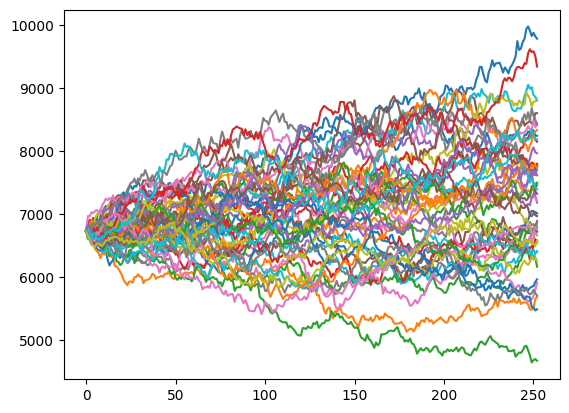

In [8]:
# Exercise price
K = 6000
# time in years
T = 1.0
# number of time steps in simulation
N = 252
# asset price
S0 = calls["S0"].iloc[0]
# risk-free rate
r = calls["r"].iloc[0]
# Divident rate <---------- need to double check
q = 0
# number of simulations
M = 100

S_path,V_path = heston_simulation(S0=S0,r=r,q=q,K=K,T=T,v0=v0,kappa=kappa,theta=theta,rho=rho,sigma=sigma,paths=M,steps=N)
plt.plot(S_path[:,:50])
plt.show()

In [9]:
# def heston_simulation(S0,r,q,K,T,v0,kappa,theta,rho,sigma,paths,steps):
#     """
#     paths:路径数
#     steps：模拟天数
#     """
#     dt = T/steps
#     S_path = np.zeros((steps+1,paths))
#     V_path = np.zeros((steps+1,paths))
#     S_path[0] = S0
#     V_path[0] = v0
    
#     for step in range(1,steps+1):
#         rn1 = np.random.standard_normal(paths) 
#         rn2 = np.random.standard_normal(paths)
#         rn2 = rho*rn1 + np.sqrt(1-rho**2)*rn2  #利用cholesky分解，重新赋值rn2确保两个相关系数为rho
        
#         S_path[step] = S_path[step - 1] * np.exp((r-q-0.5*V_path[step-1])*dt + np.sqrt(V_path[step-1])*np.sqrt(dt)*rn1) #几何布朗运动的解
#         V_path[step] = (np.sqrt(V_path[step - 1]) + sigma/2*np.sqrt(dt)*rn2)**2 + kappa*(theta-V_path[step - 1])*dt - sigma**2/4*dt 
#         V_path[step] = np.maximum(V_path[step],0)  #避免v取到负数，和0取大作为结果
        
#     value = np.maximum(S_path[-1] - K,0).mean()   
    
#     return S_path,V_path,value

In [10]:
# def payoff_shark_fin_call(S_array, K, B):
#     """
#     单步近似：
#       若最终价 S_T >= B，则认为障碍被触及 => Payoff = 0
#       否则 Payoff = max(S_T - K, 0)
#     """
#     return np.where(S_array >= B, 0.0, np.maximum(S_array - K, 0.0))